In [1]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import time
import sys
import os
import h5py
from os import listdir
from os.path import isfile, join
from sklearn.decomposition import PCA
from scipy import signal

In [2]:
def get_spectrogram(pca_data):
    f,t,s = signal.spectrogram(pca_data[:, 0], 
                        fs=2000, 
                        window=signal.windows.gaussian(1024, (1024-1)/5), 
                        nperseg=1024, 
                        noverlap=986, 
                        nfft=1024, 
                        mode='complex') 
    x=np.zeros((80, t.shape[0]))
    for k in range(1, pca_data.shape[-1]):
        f,t,s = signal.spectrogram(pca_data[:, k], 
                            fs=2000, 
                            window=signal.windows.gaussian(1024, (1024-1)/5), 
                            nperseg=1024, 
                            noverlap=986, 
                            nfft=1024, 
                            mode='complex')         
        s_magnitude=np.abs(s)
        s_first80=s_magnitude[:80, :]
        s_enery_level=np.sum(s_first80)
        a_magnitude_norm=s_first80/s_enery_level
        s_magnitude_mean=np.mean(a_magnitude_norm, axis=-1)
        s_magnitude_denoise=(a_magnitude_norm.T-s_magnitude_mean).T
        index=np.where(s_magnitude_denoise < 0)
        s_magnitude_denoise[index]=0
        x+=s_magnitude_denoise
    return x

In [2]:
def get_csi_dict(x):
    data = []
    for i in range(len(x['csi_trace'])):
        array = {}
        array["timestamp"] = np.squeeze(x['csi_trace'][i][0][0][0][0]) 
        array["csi_len"] = np.squeeze(x['csi_trace'][i][0][0][0][1]) 
        array["channel"] = np.squeeze(x['csi_trace'][i][0][0][0][2]) 
        array["err_info"] = np.squeeze(x['csi_trace'][i][0][0][0][3]) 
        array["noise_floor"] = np.squeeze(x['csi_trace'][i][0][0][0][4]) 
        array["Rate"] = np.squeeze(x['csi_trace'][i][0][0][0][5]) 
        array["bandWidth"] = np.squeeze(x['csi_trace'][i][0][0][0][6]) 
        array["num_tones"] = np.squeeze(x['csi_trace'][i][0][0][0][7]) 
        array["nr"] = np.squeeze(x['csi_trace'][i][0][0][0][8]) 
        array["nc"] = np.squeeze(x['csi_trace'][i][0][0][0][9]) 
        array["rssi"] = np.squeeze(x['csi_trace'][i][0][0][0][10]) 
        array["rssi1"] = np.squeeze(x['csi_trace'][i][0][0][0][11]) 
        array["rssi2"] = np.squeeze(x['csi_trace'][i][0][0][0][12]) 
        array["rssi3"] = np.squeeze(x['csi_trace'][i][0][0][0][13]) 
        array["payload_len"] = np.squeeze(x['csi_trace'][i][0][0][0][14]) 
        array["csi"] = np.squeeze(x['csi_trace'][i][0][0][0][15]) 
        data.append(array)
    return data

def get_csi_array(csi_data):
    csi_array = []
    for i in range(len(csi_data)):
        if csi_data[i]['nc'] == 3:
            csi_array.append(csi_data[i]['csi'])
    return np.array(csi_array)

def power_delay_profile(data, keep_bins=30):
    data = np.concatenate([np.zeros([data.shape[0], data.shape[1], data.shape[2], 1]), data, np.expand_dims(data[..., -1], axis=-1)], axis=-1)
    pdf = np.fft.irfft(data, axis=-1)
    pdf[..., keep_bins:] = 0
    return np.fft.fft(pdf, n=(data.shape[-1]*2)+2, axis=-1)[..., 1:data.shape[-1]-1]

def db(X):
    X = np.square(np.abs(X))+1e-6
    Y = (10*np.log10(X)+300)-300
    return Y

def spectral_centroid(x, samplerate=1000):
    magnitudes = np.abs(np.fft.rfft(x)) # magnitudes of positive frequencies
    length = len(x)
    freqs = np.abs(np.fft.fftfreq(length, 1.0/samplerate)[:length//2+1]) # positive frequencies
    return np.sum(magnitudes*freqs) / np.sum(magnitudes) 

In [92]:
data = get_csi_array(get_csi_dict(loadmat("/home/kjakkala/neuralwave/data/kalvik_test/para_pp1.mat")))
print(data.shape, data.dtype)

(60094, 3, 3, 114) complex128


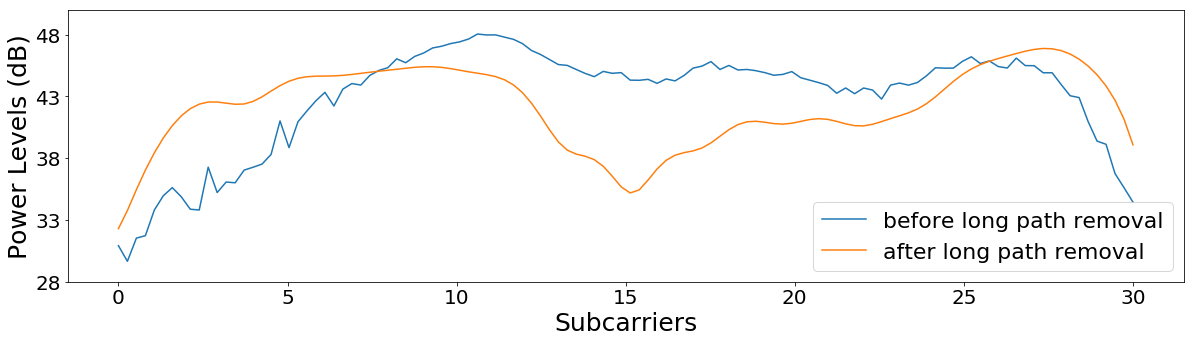

In [131]:
plt.figure(figsize=(20,5))
plt.plot(np.linspace(0, 30, 114), db((data[0, 0, 0])), label="before long path removal")
plt.plot(np.linspace(0, 30, 114), db(power_delay_profile(data)[0, 0, 0]), label="after long path removal")

plt.xticks(fontsize=20)
plt.yticks(np.arange(28, 50, 5), fontsize=20)
plt.ylim((28, 50))
plt.legend(prop={'size': 22})
plt.ylabel("Power Levels (dB)", fontsize= 25)
plt.xlabel("Subcarriers", fontsize= 25)
plt.savefig("long_path_removal.png", bbox_inches='tight', dpi=150)

In [4]:
data = np.concatenate([np.zeros([data.shape[0], data.shape[1], data.shape[2], 1]), data, np.expand_dims(data[..., -1], axis=-1)], axis=-1)
pdf = np.fft.irfft(data, axis=-1)

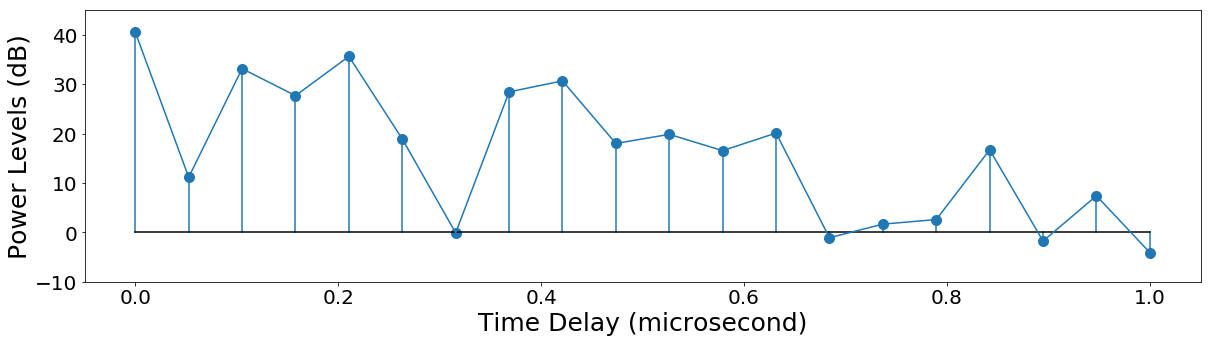

In [89]:
plt.figure(figsize=(20,5))
markerline, stemlines, baseline = plt.stem(np.linspace(0, 1, 20),db((pdf[0, 0, 0, :20])[:]), 'C0-', 'C0o', 'k')
plt.setp(markerline, markersize=10)
plt.plot(np.linspace(0, 1, 20),db((pdf[0, 0, 0, :20])[:]))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim((-10, 45))
plt.xlim((0, 1))
plt.ylabel("Power Levels (dB)", fontsize= 25)
plt.xlabel("Time Delay (microsecond)", fontsize= 25)
plt.savefig("test1.png", bbox_inches='tight', dpi=150)

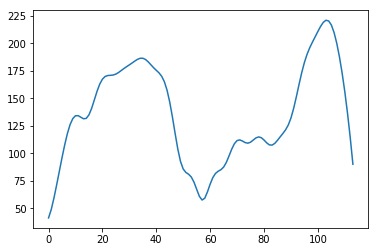

In [20]:
plt.plot(data[0, 0, 0])

In [10]:
I_measure = []
for tx in range(3):
    for rx in range(3):
        I_noise = []
        for i in range(0, data.shape[0], 300):
            pca = PCA(n_components=2)
            pca_data = pca.fit_transform(data[i:i+400, tx, rx])
            eigenvectors = pca.components_
            I_noise.append(np.var(pca_data[:, 1])/np.mean(np.abs(np.diff(eigenvectors[1]))))
                    
        I_measure.append(I_noise)
I_measure = np.array(I_measure)
mean_I_measure = np.mean(I_measure, axis=0)
I_measure.shape

(9, 201)

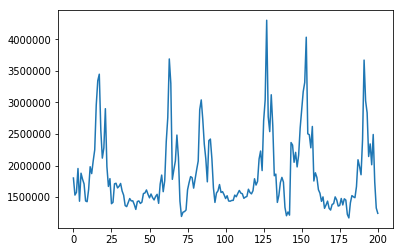

In [11]:
plt.plot(mean_I_measure)

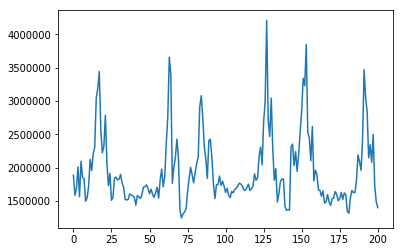

In [191]:
plt.plot(mean_I_measure)

In [ ]:
for window in range(2, 6):
    rms = []
    for i in range(0, len(mean_I_measure), window):
        rms.append(np.mean(np.square(mean_I_measure[i:i+5])))
    plt.plot(rms)
    plt.show()

In [ ]:
for window in range(2, 6):
    rms = []
    for i in range(0, len(mean_I_measure), window):
        rms.append(np.mean(np.square(mean_I_measure[i:i+5])))
    plt.plot(rms)
    plt.show()

In [ ]:
for window in range(2, 6):
    rms = []
    for i in range(0, len(mean_I_measure), window):
        rms.append(np.mean(np.square(mean_I_measure[i:i+5])))
    plt.plot(rms)
    plt.show()

In [ ]:
n_point = 5
gamma = 0.1
L_noise = []
L_noise.append(np.mean(I_measure[0, :n_point]))
I_loss_tmp = I_measure[0, n_point:]

for i in range(1, len(I_loss_tmp)):
    if (i < n_point):
        L_noise.append(((1 - gamma) * L_noise[-1]) + (gamma * np.var(I_loss_tmp[:i]))) 
    else:
        L_noise.append(((1 - gamma) * L_noise[-1]) + (gamma * np.var(I_loss_tmp[i-n_point:i])))         
plt.plot(L_noise) 
plt.show()
for window in range(2, 6):
    rms = []
    for i in range(0, len(mean_I_measure), window):
        rms.append(np.mean(np.square(mean_I_measure[i:i+5])))
    plt.plot(rms)
    plt.show()

In [ ]:
data = np.abs(long_delay_removal(get_csi_array(get_csi_dict(loadmat("/home/kjakkala/neuralwave/data/kalvik_test/perp_pp1.mat")))))
print(data.shape, data.dtype)

In [ ]:
pca = PCA(n_components=20)
pca_data = pca.fit_transform(data.reshape(-1, 3*3*114))
spect = get_spectrogram(pca_data)

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(spect.shape[0]):
    plt.plot(spect[i, :300])
plt.gca().invert_yaxis()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(spect[:, :])
plt.gca().invert_yaxis()
plt.show()

In [ ]:
for i in range(0, spect.shape[1], 300):
    plt.figure(figsize=(20, 10))
    plt.imshow(spect[5:, i:i+300])
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(spect[:, :])
plt.gca().invert_yaxis()
plt.show()

In [ ]:
for i in range(0, spect.shape[1], 300):
    plt.figure(figsize=(20, 10))
    plt.imshow(spect[5:, i:i+300])
    plt.gca().invert_yaxis()
    plt.show()